In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("completed_Apples_stock price dataset.csv" )
df.head()

,Unnamed: 0.1,Unnamed: 0,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment,date,time
0,0,4,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077,2010-01-01,04:00:00
1,1,5,2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119,2010-01-01,05:00:00
2,2,6,2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849,2010-01-01,06:00:00
3,3,7,2010-01-01 07:00:00,104.107075,8027.722289,3015.504909,4.056720,3.377880,3.276263,0.002849,2010-01-01,07:00:00
4,4,8,2010-01-01 08:00:00,97.961085,8029.541811,3020.187389,2.099831,4.815785,1.761161,-0.634609,2010-01-01,08:00:00


In [4]:
import json
try:
    with open("model_scores.json", "r") as f:
            final_scores = json.load(f)
except FileNotFoundError: 
    final_scores = {}   # start fresh if file doesn't exist

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

# --- Define parameter grids ---
trend_options = ["add", "mul", None]
seasonal_options = ["add", "mul", None]
seasonal_periods_options = [7, 12, 365]  # adjust based on your data frequency

best_config = None
best_aic = float("inf")
best_rmse = float("inf")
best_r2 = float("inf")
best_mae = float("inf")

# --- Train-test split ---
train_size = int(len(df) * 0.8)
train, test = df['stock_price'][:train_size], df['stock_price'][train_size:]


C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
2026/01/31 08:07:14 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/31 08:07:14 INFO mlflow.store.db.utils: Updating database tables
2026/01/31 08:07:14 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/31 08:07:14 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/31 08:07:15 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/31 08:07:15 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/31 08:07:15 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GI

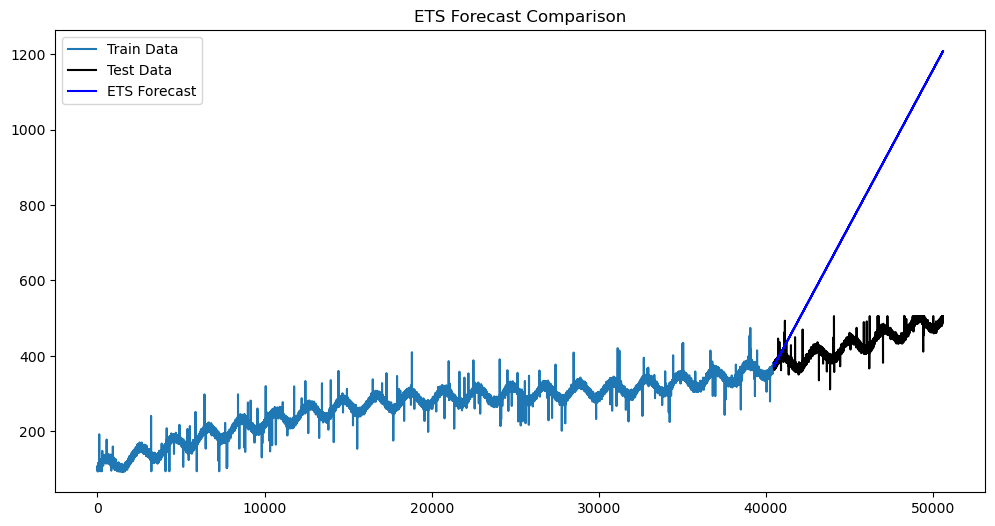

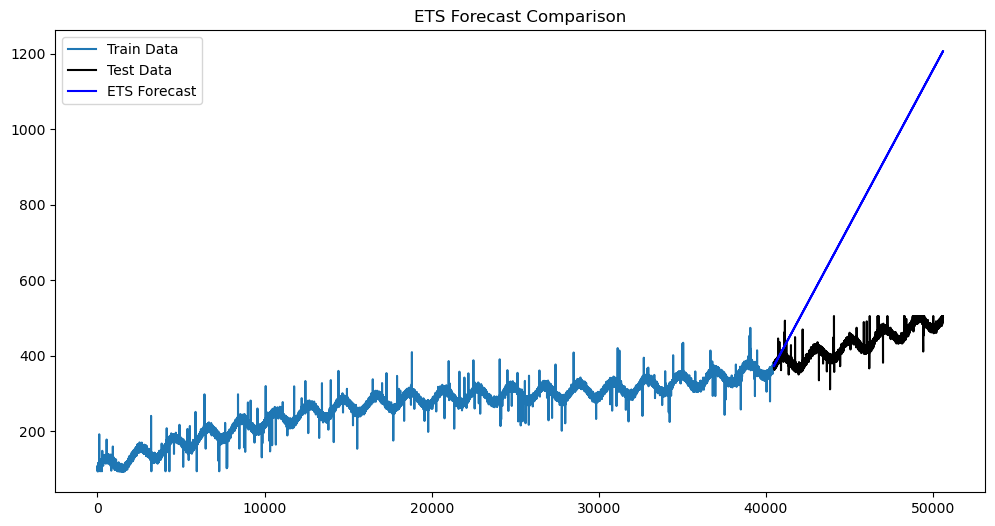

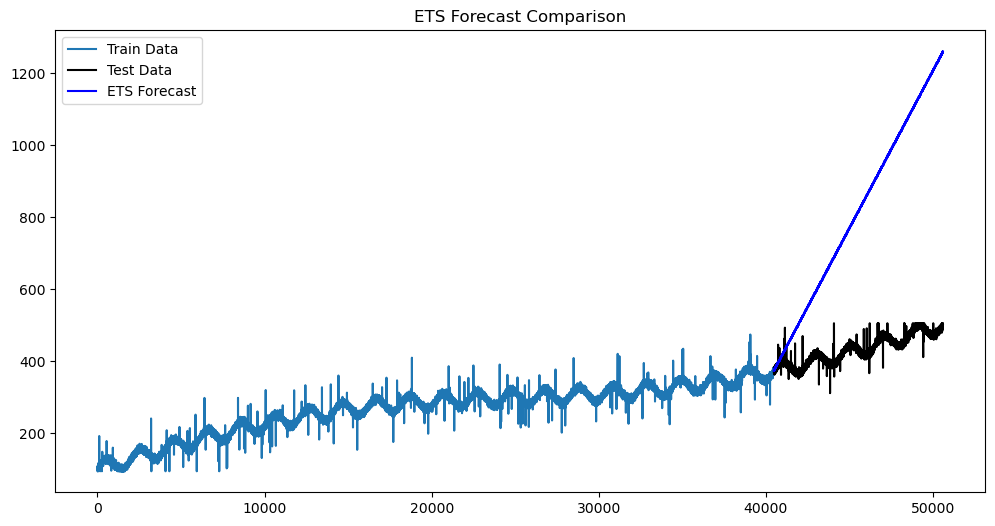

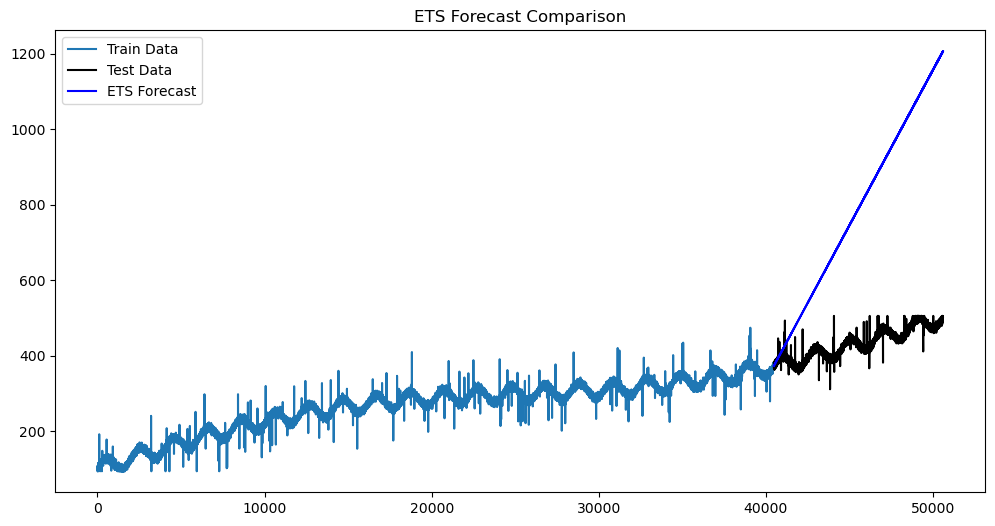

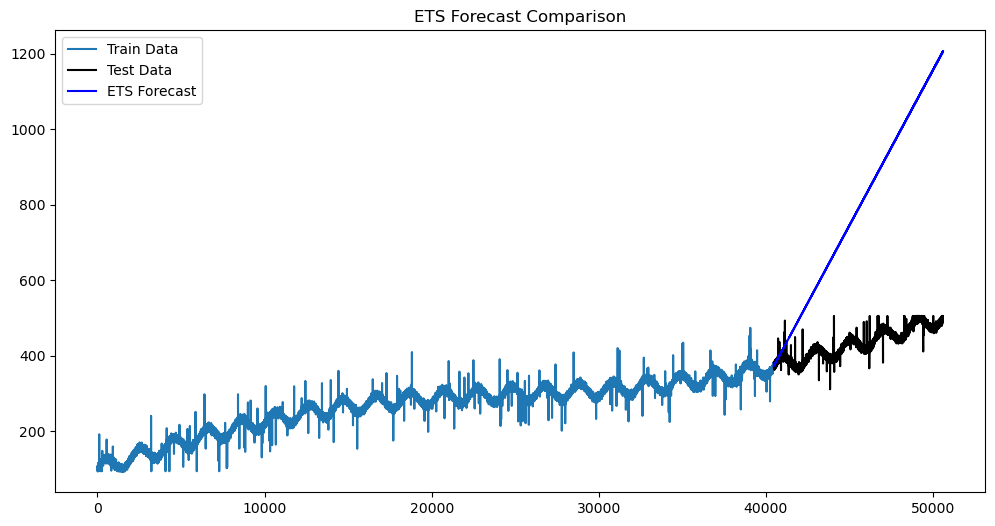

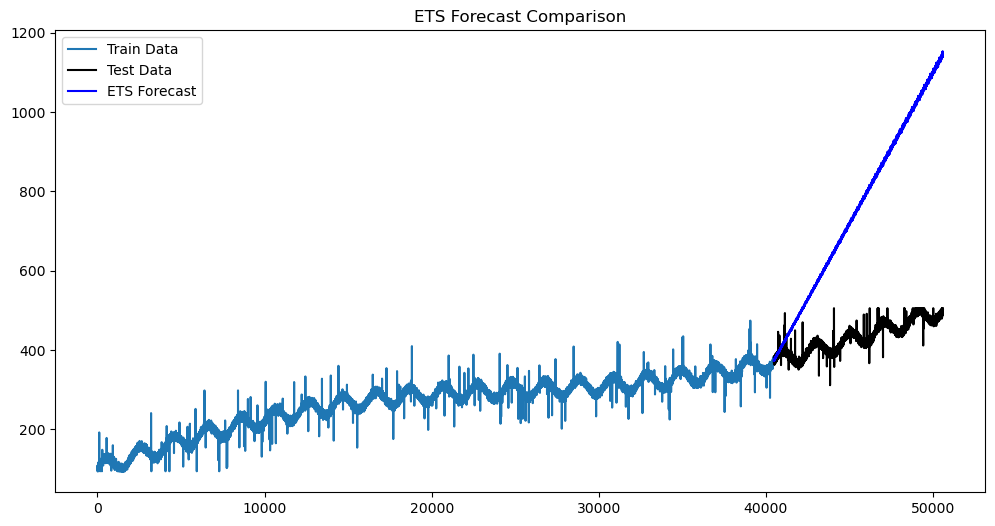

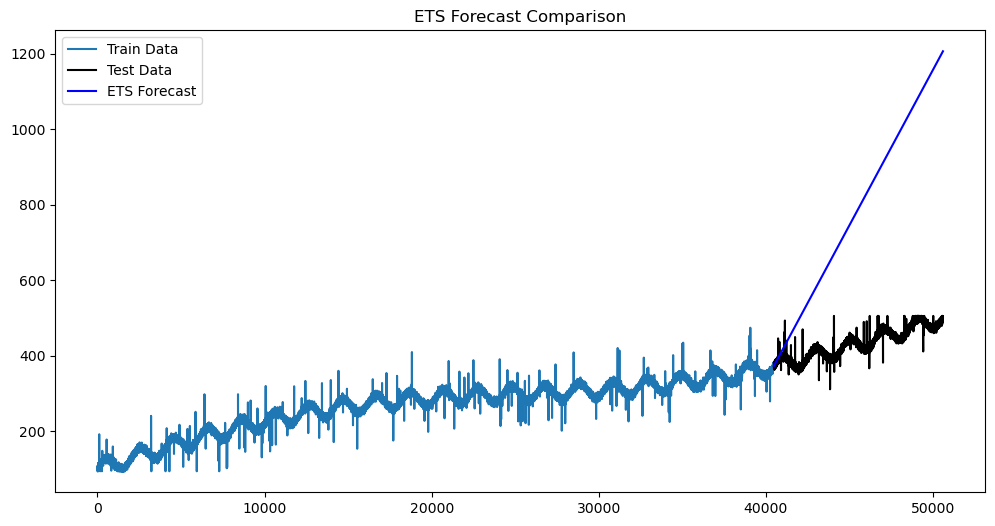

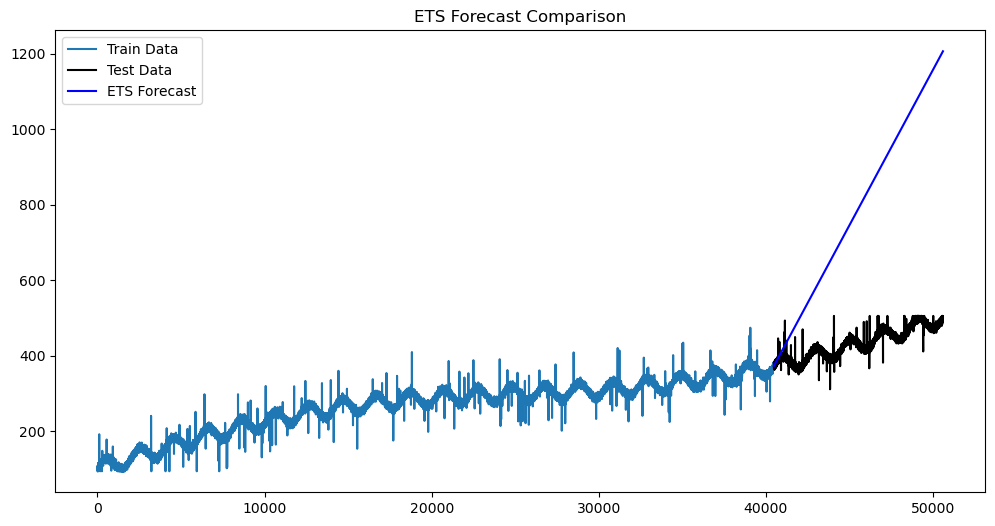

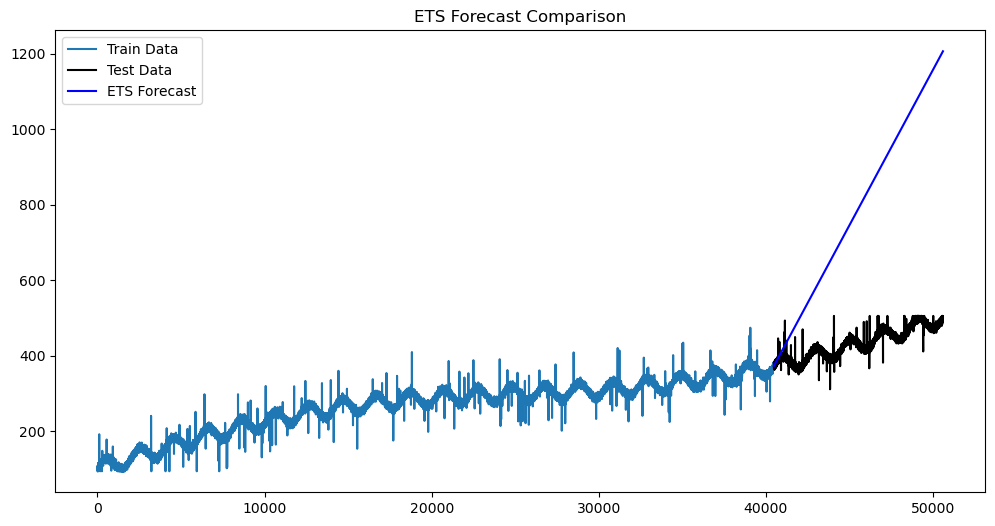

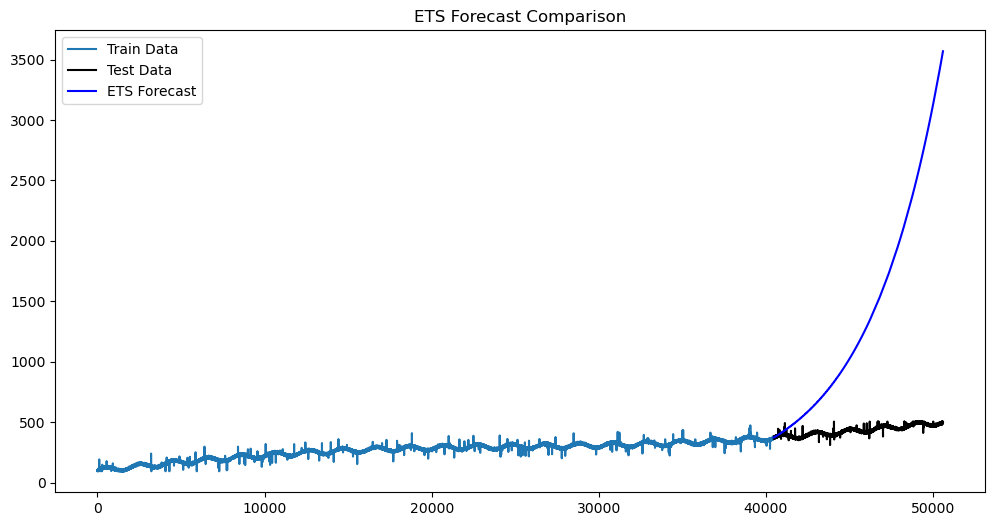

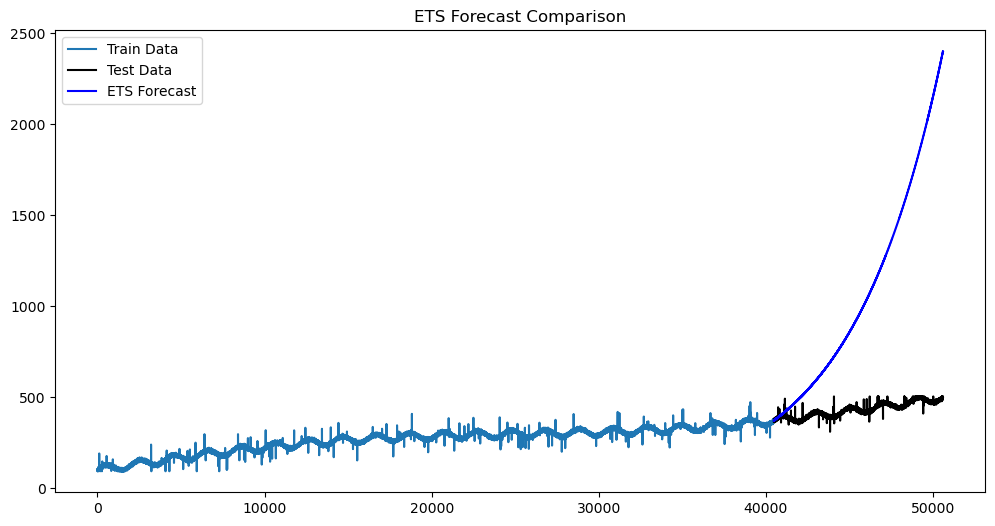

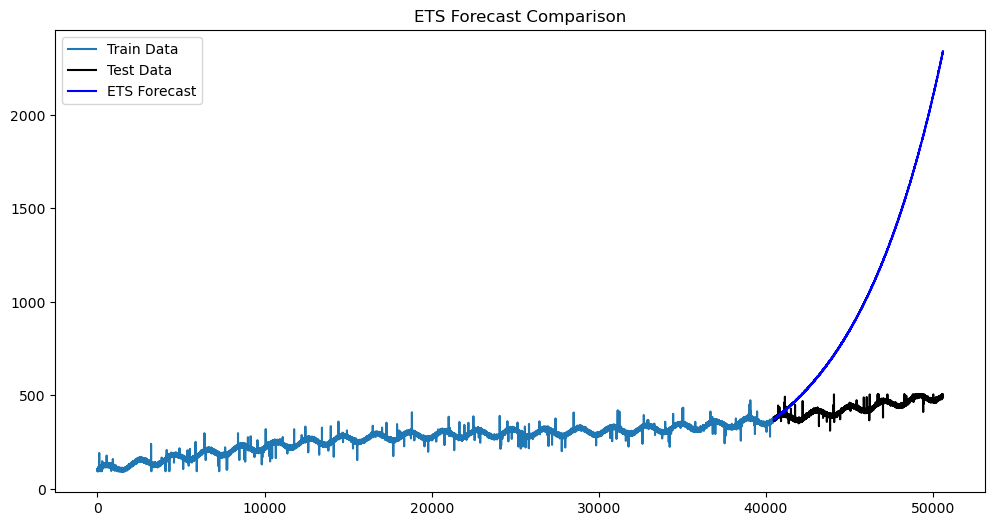

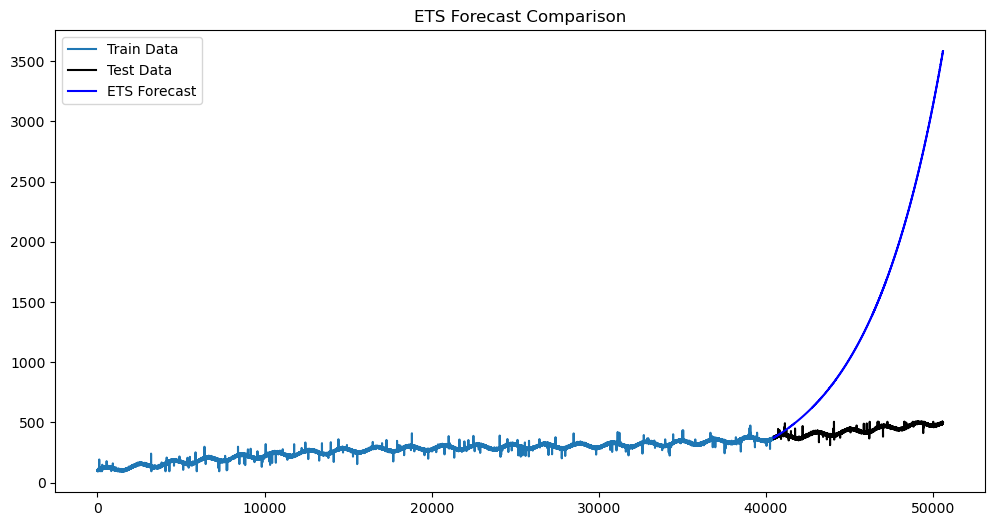

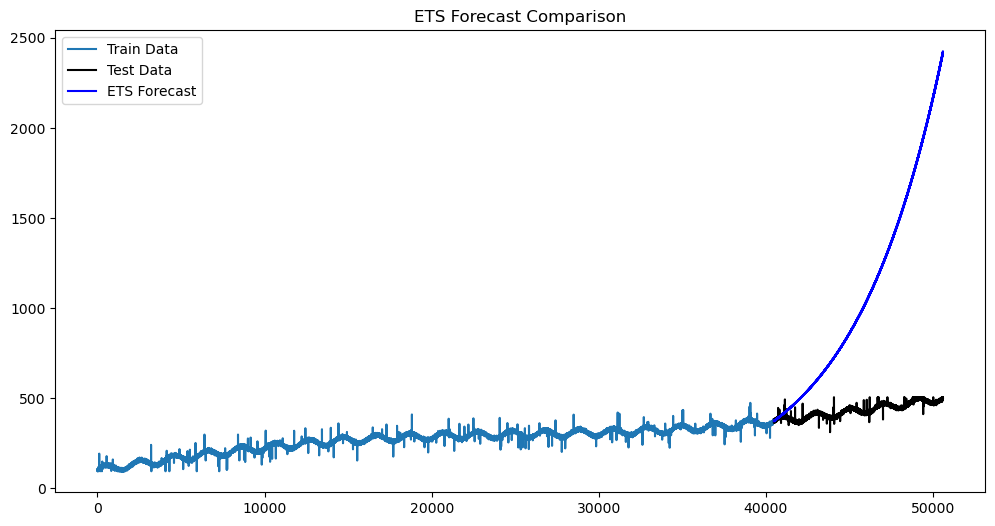

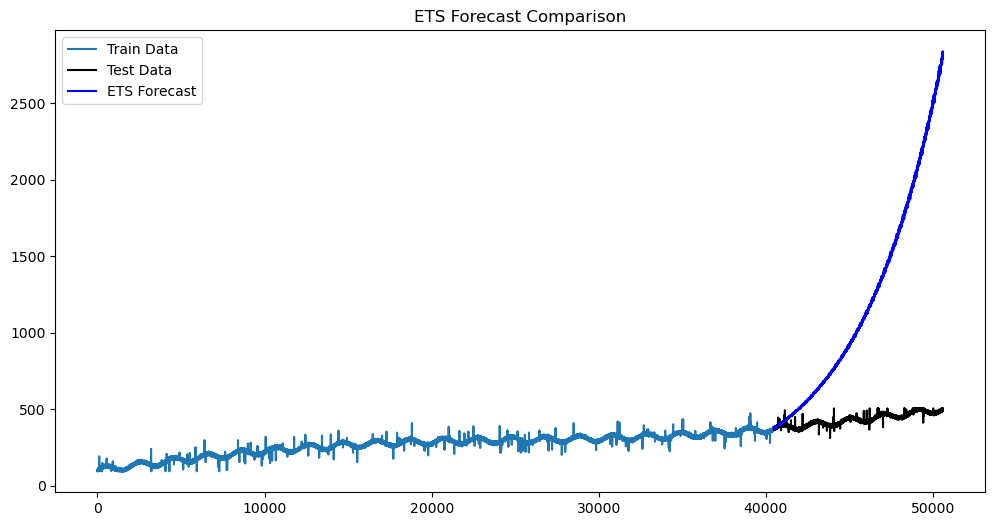

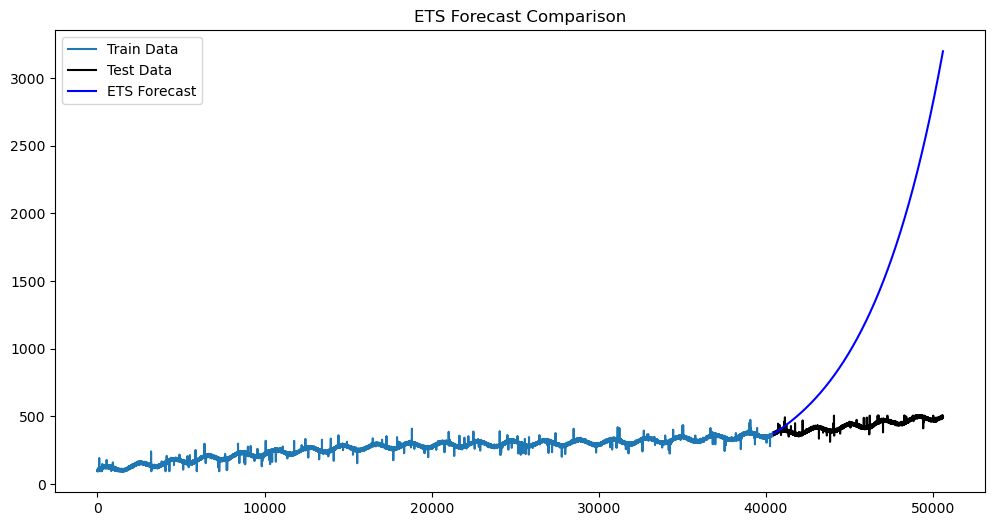

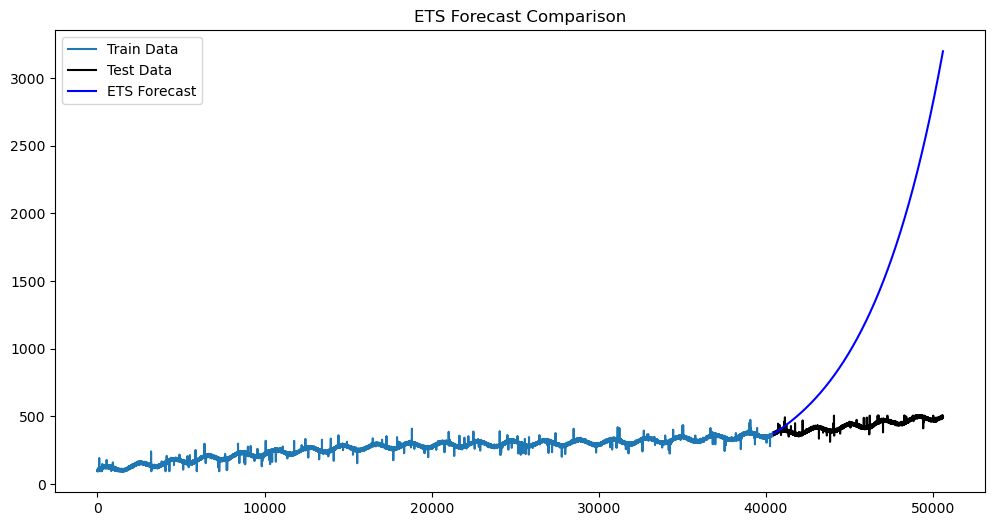

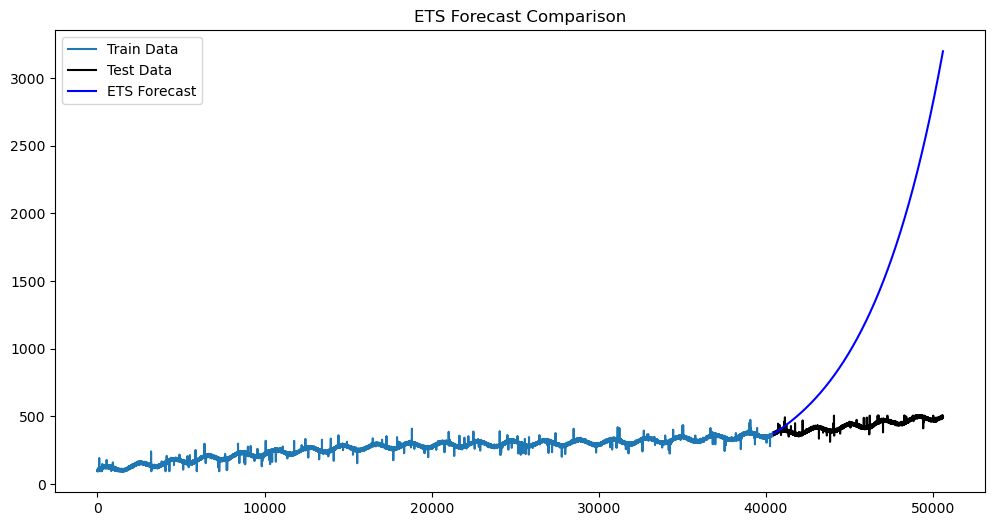

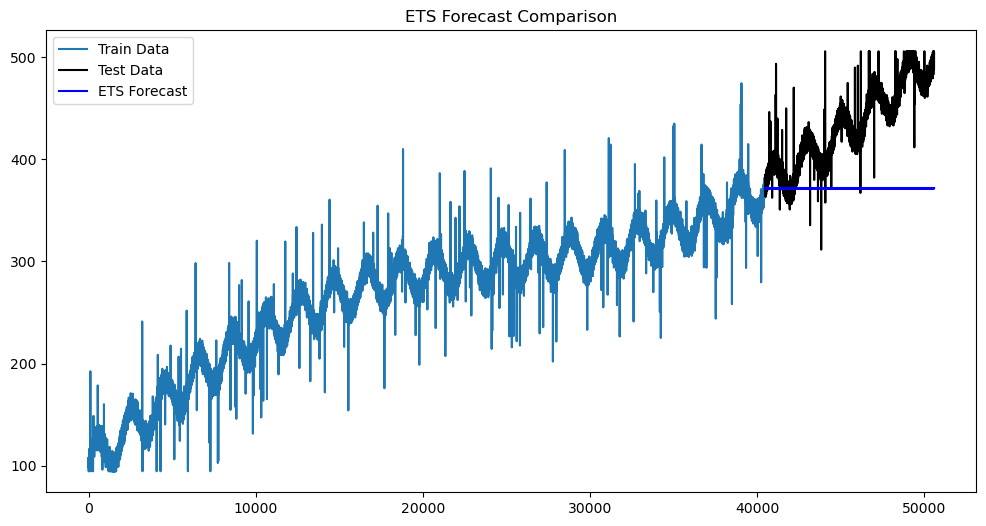

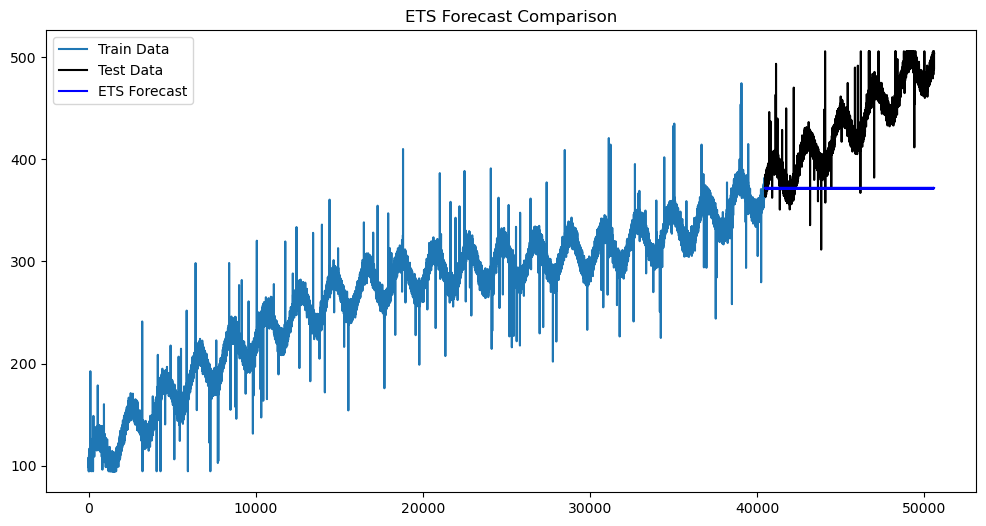

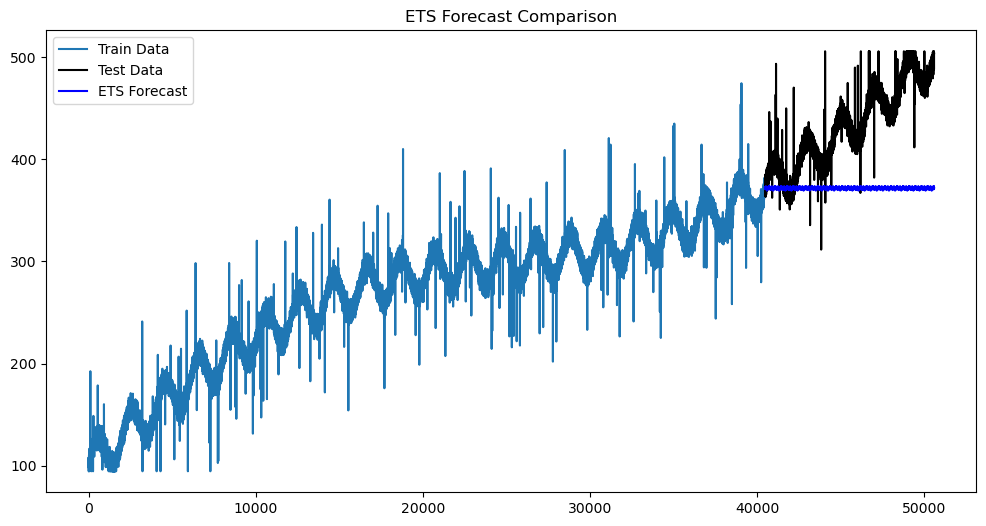

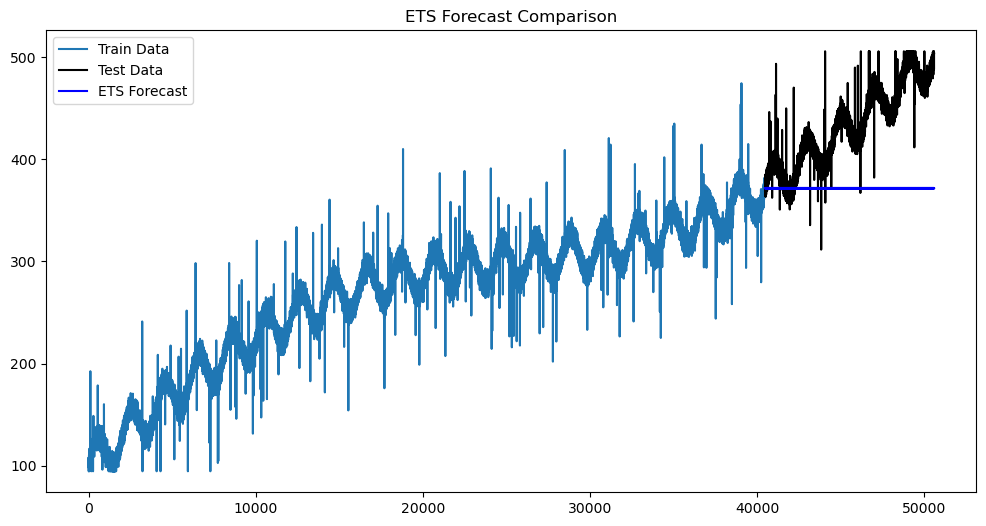

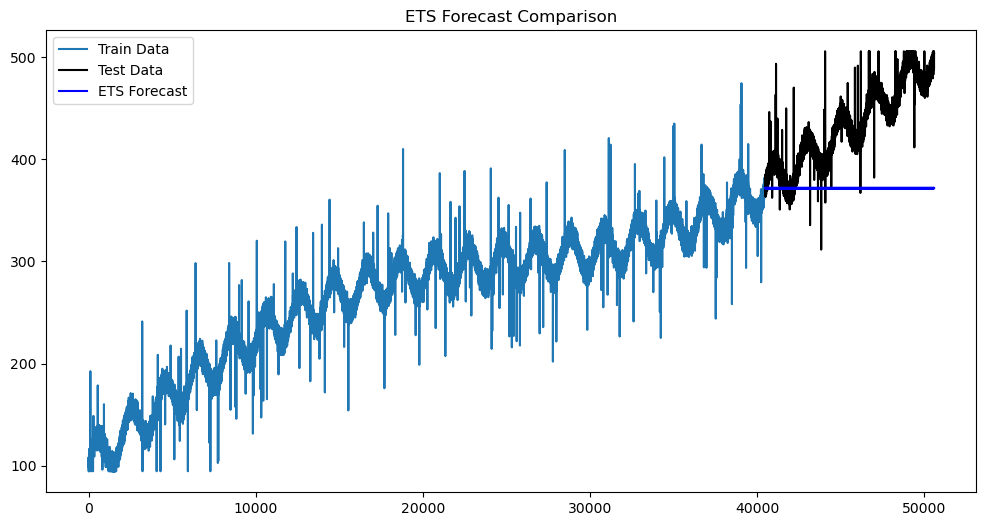

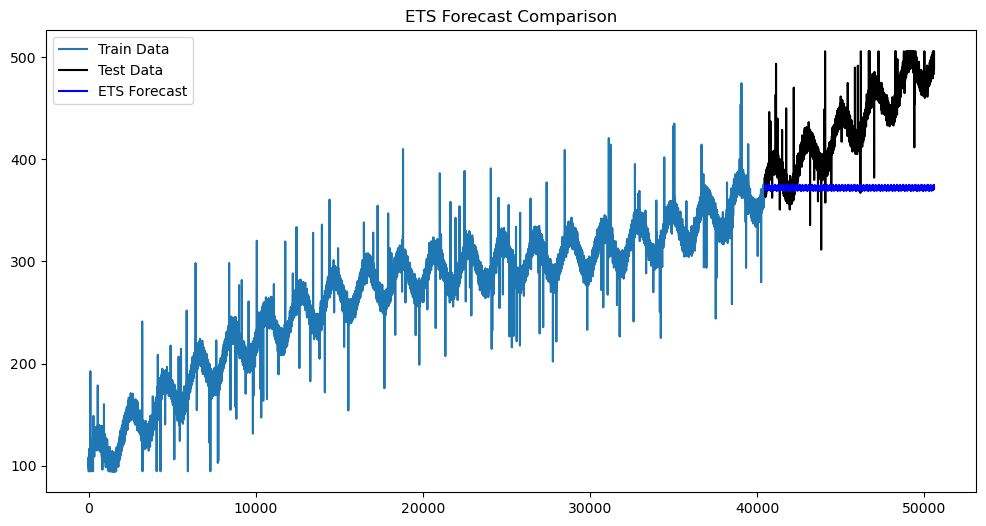

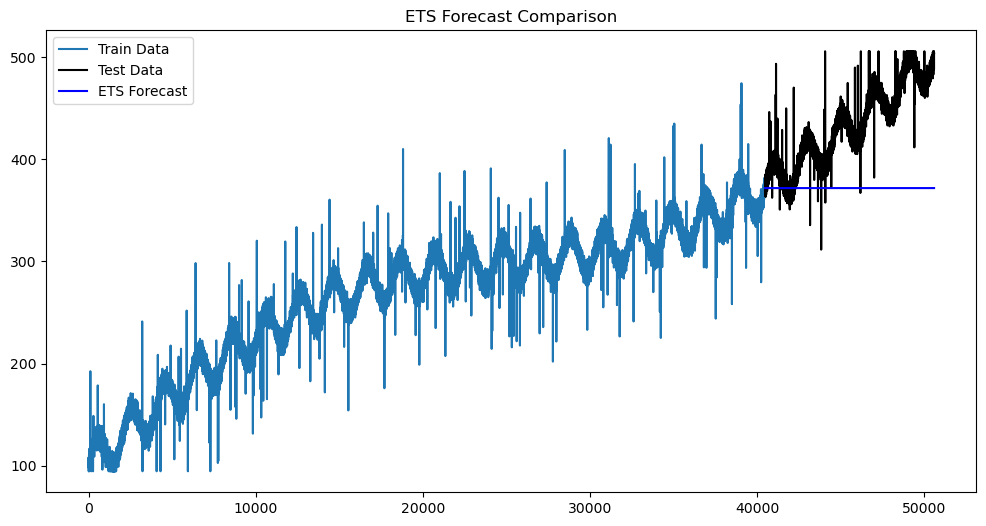

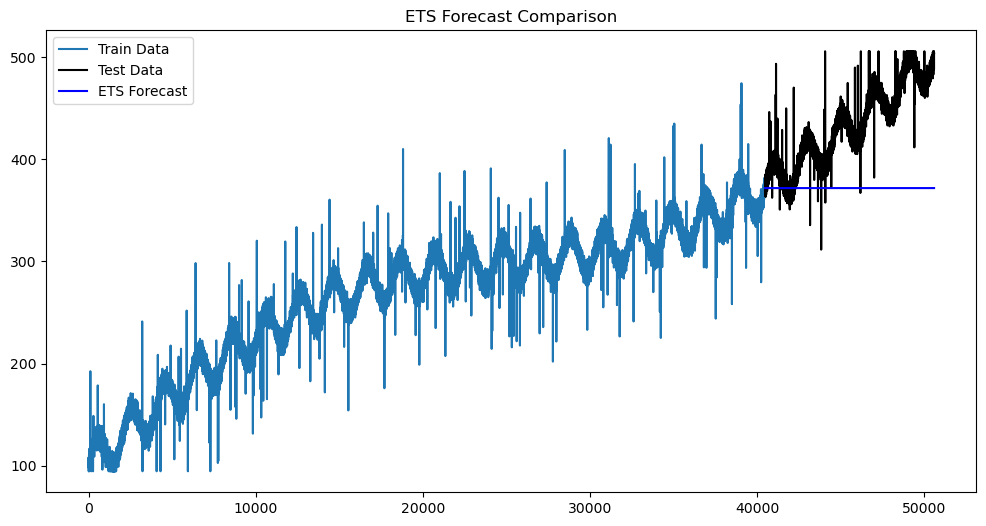

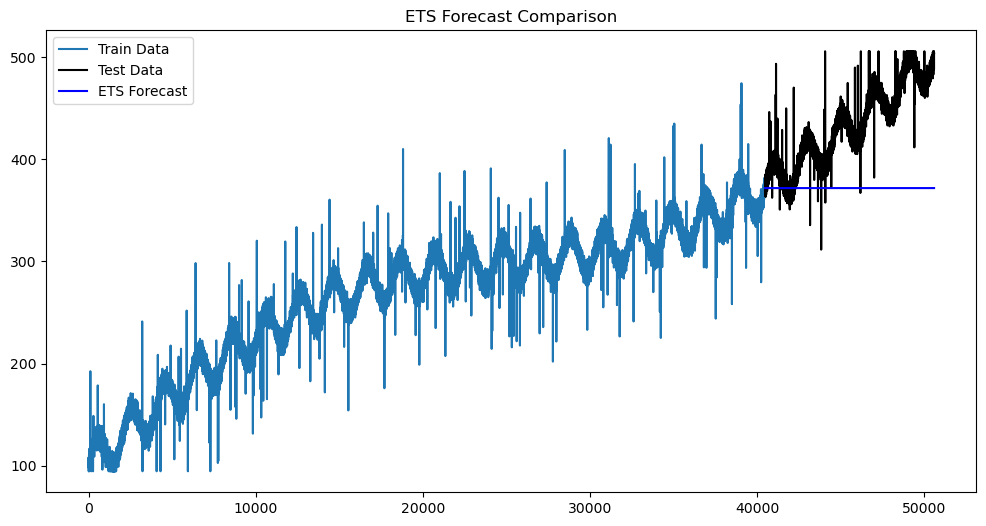

In [6]:
for trend in trend_options:
    for seasonal in seasonal_options:
        for sp in seasonal_periods_options:
            ets_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=sp)
            ets_fit = ets_model.fit()
            ets_forecast = ets_fit.forecast(len(test))
            # Evaluate
            
            AIC = ets_fit.aic
            BIC = ets_fit.bic
            RMSE = root_mean_squared_error(test, ets_forecast)
            MAE = mean_absolute_error(test, ets_forecast)
            r2   = r2_score(test, ets_forecast)
            print(f"Trend={trend}, Seasonal={seasonal}, SeasonalPeriods={sp} | AIC={aic:.2f}, RMSE={rmse:.2f}")
            
            # --- Plot comparison ---
            plt.figure(figsize=(12,6))
            plt.plot(train.index, train, label="Train Data")
            plt.plot(test.index, test, label="Test Data", color="black")
            plt.plot(test.index, ets_forecast, label="ETS Forecast", color="blue")
            
            plt.legend()
            plt.title("ETS Forecast Comparison")
            plt.savefig(f"ETS_{trend_options}_{seasonal_options}_{seasonal_periods_options}.png")  

        with mlflow.start_run(run_name=f"ETS_{trend_options}_{seasonal_options}_{seasonal_periods_options}"):
            mlflow.log_param("trend_options", trend_options)  
            mlflow.log_param("seasonal_options", seasonal_options)  
            mlflow.log_param("seasonal_periods_options", seasonal_periods_options)  
            mlflow.log_metric("AIC", float(AIC))
            mlflow.log_metric("BIC", float(BIC))
            mlflow.log_metric("RMSE", float(RMSE))
            mlflow.log_metric("r2Square", float(r2))
            mlflow.log_artifact(f"ETS_{trend_options}_{seasonal_options}_{seasonal_periods_options}.png") 
            mlflow.sklearn.log_model(ets_model, name="ETS")
        
            # Track best model
            if AIC < best_aic:
                best_aic = AIC
                best_rmse = RMSE                        
                best_r2 = r2
                best_mae = MAE
                best_config = (trend, seasonal, sp)

In [7]:
print("\nBest ETS configuration:")
print(f"Trend={best_config[0]}, Seasonal={best_config[1]}, SeasonalPeriods={best_config[2]} | AIC={best_aic:.2f}, RMSE={best_rmse:.2f}")


Best ETS configuration:
Trend=add, Seasonal=None, SeasonalPeriods=365 | AIC=150970.83, RMSE=412.26


In [8]:
final_scores["ETS"] = {"AIC": best_aic, "RMSE": best_rmse, "R2": best_r2, "MAE": best_mae }

150970.83196574057


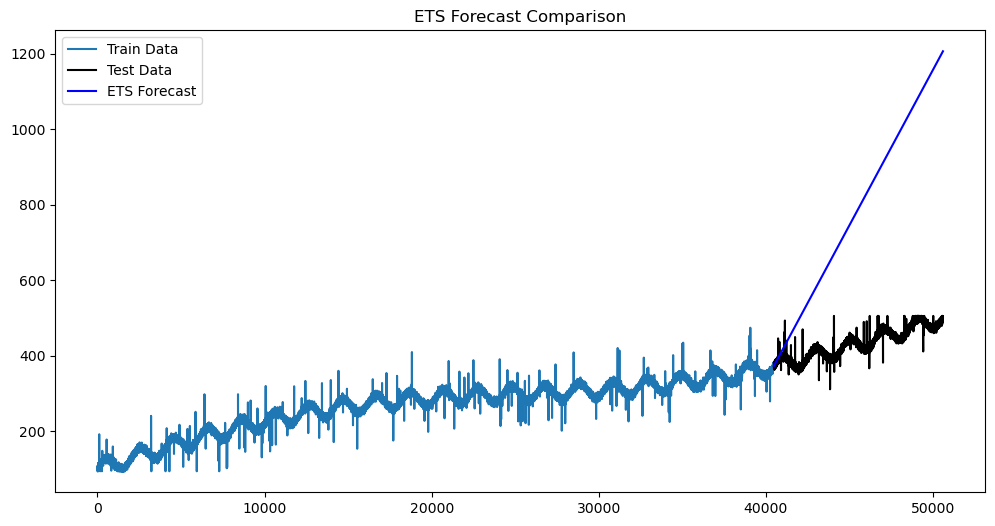

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# --- Exponential Smoothing (ETS/Holt-Winters) ---
ets_model = ExponentialSmoothing(train, trend=best_config[0], seasonal=best_config[1], seasonal_periods=best_config[2])
ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(len(test))
print(ets_fit.aic)

# --- Plot comparison ---
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train Data")
plt.plot(test.index, test, label="Test Data", color="black")
plt.plot(test.index, ets_forecast, label="ETS Forecast", color="blue")
plt.legend()
plt.title("ETS Forecast Comparison")
plt.show()

In [10]:
import json

# Save model score
with open("model_scores.json", "w") as f:
    json.dump(final_scores, f, indent=4)